In [816]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime

data = pd.read_parquet(Path("data") / "train.parquet")
missing_values_count = data.isnull().any(axis=1).sum()
print(f"Number of lines with missing values: {missing_values_count}")

data = data.dropna()
data.dtypes
print(data)

Number of lines with missing values: 0
                 counter_id                counter_name    site_id  \
48321   100007049-102007049    28 boulevard Diderot E-O  100007049   
48324   100007049-102007049    28 boulevard Diderot E-O  100007049   
48327   100007049-102007049    28 boulevard Diderot E-O  100007049   
48330   100007049-102007049    28 boulevard Diderot E-O  100007049   
48333   100007049-102007049    28 boulevard Diderot E-O  100007049   
...                     ...                         ...        ...   
929175  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929178  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929181  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929184  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929187  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   

                   site_name  bike_count                date  \
48321   28 boulevard Diderot         0.0 2020-09-01 02:0

On a importé et checké si il y avait des valeurs manquantes dans le dataset

In [817]:
def _encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    return X

data = _encode_dates(data)
min_date = data['date'].min().strftime('%Y-%m-%d')
max_date = data['date'].max().strftime('%Y-%m-%d')

In [818]:
import holidays
vancances = holidays.CountryHoliday('France')

data["IsHolidays"] = data["date"].isin(vancances).astype(int)
data['IsWeekend'] = data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

Étudions l'influence de la météo sur nos données. On importe pour celà les données météo de la ville de Paris sur la durée d'étude.

In [819]:
data_meteo = pd.read_csv('external_data/export-paris0.csv')
data_meteo = data_meteo.drop(columns = ['TEMPERATURE_NIGHT_C', 'SUNRISE', 'SUNSET'] )


On restreint à ('2020-09-01 01:00:00) - ('2021-09-09 23:00:00')

In [820]:
data_meteo = data_meteo[(data_meteo['DATE'] > min_date) & (data_meteo['DATE'] < max_date)]
data_meteo['DATE'] = pd.to_datetime(data_meteo['DATE'])
data_meteo["year"] = data_meteo["DATE"].dt.year
data_meteo["month"] = data_meteo["DATE"].dt.month
data_meteo["day"] = data_meteo["DATE"].dt.day
data_meteo

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,...,WEATHER_CODE_MORNING,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION,year,month,day
4262,2020-09-02,25,15,9,15,22,23,0.0,69,10.0,...,113,113,113,0.0,6,11.6,météo idéale,2020,9,2
4263,2020-09-03,26,16,12,16,23,26,0.0,54,10.0,...,116,116,116,0.0,6,11.6,météo favorable,2020,9,3
4264,2020-09-04,29,20,10,20,27,28,0.0,75,10.0,...,116,116,116,0.0,7,11.6,météo favorable,2020,9,4
4265,2020-09-05,22,17,13,17,20,20,0.1,73,10.0,...,176,119,116,0.0,5,10.3,météo correcte,2020,9,5
4266,2020-09-06,19,14,9,14,18,19,0.3,68,10.0,...,116,176,176,0.0,5,9.1,météo favorable,2020,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4629,2021-09-04,28,18,6,18,26,24,0.4,87,10.0,...,353,116,176,0.0,6,9.1,météo correcte,2021,9,4
4630,2021-09-05,31,18,8,18,31,29,0.0,66,10.0,...,116,116,116,0.0,7,11.6,météo favorable,2021,9,5
4631,2021-09-06,30,19,10,19,30,28,0.0,72,10.0,...,116,116,116,0.0,7,11.6,météo favorable,2021,9,6
4632,2021-09-07,31,19,18,19,30,29,0.0,75,10.0,...,113,116,113,0.0,7,11.6,météo favorable,2021,9,7


In [821]:
data = pd.merge(data, data_meteo, on=['year', 'month', 'day'])

In [822]:
print(data)
print(data.columns)

                 counter_id                counter_name    site_id  \
0       100007049-102007049    28 boulevard Diderot E-O  100007049   
1       100007049-102007049    28 boulevard Diderot E-O  100007049   
2       100007049-102007049    28 boulevard Diderot E-O  100007049   
3       100007049-102007049    28 boulevard Diderot E-O  100007049   
4       100007049-102007049    28 boulevard Diderot E-O  100007049   
...                     ...                         ...        ...   
494236  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
494237  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
494238  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
494239  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
494240  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   

                   site_name  bike_count                date  \
0       28 boulevard Diderot         0.0 2020-09-02 04:00:00   
1       28 boulevard Diderot   

Le dataframe est complet, on peut maintenant commencer à chercher des estimateurs

In [823]:
corr = data.select_dtypes('number').corr()
corr


,site_id,bike_count,latitude,longitude,log_bike_count,year,month,day,weekday,hour,...,CLOUDCOVER_AVG_PERCENT,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_MORNING,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR
site_id,1.000000,-0.003354,-0.129588,-0.188871,0.021096,0.084464,-0.061769,0.004645,0.000222,0.000006,...,0.000243,-0.001782,-0.003480,-0.013976,0.000901,0.005933,0.010795,0.007375,-0.004712,0.028494
bike_count,-0.003354,1.000000,0.132049,0.014832,0.738555,-0.016835,0.030928,-0.013166,-0.076499,0.132036,...,-0.095805,0.153231,0.114388,0.136542,-0.038842,-0.055930,-0.059354,-0.044286,0.147441,0.110289
latitude,-0.129588,0.132049,1.000000,0.153884,0.113181,-0.010496,0.007325,-0.000127,-0.000051,-0.000017,...,-0.000096,-0.000018,0.000009,0.001428,-0.000260,-0.000895,-0.001180,-0.001015,0.000389,-0.003691
longitude,-0.188871,0.014832,0.153884,1.000000,0.044623,-0.013552,0.008078,0.001626,-0.000121,-0.000021,...,-0.000356,-0.000975,-0.001714,0.000593,-0.000988,-0.001853,-0.000778,-0.001847,-0.000273,-0.005352
log_bike_count,0.021096,0.738555,0.113181,0.044623,1.000000,-0.005101,0.055396,-0.013316,-0.055327,0.273064,...,-0.081733,0.177696,0.144233,0.167592,-0.031979,-0.050287,-0.048921,-0.053621,0.168615,0.124300
year,0.084464,-0.016835,-0.010496,-0.013552,-0.005101,1.000000,-0.796487,-0.030343,0.002195,-0.000259,...,-0.098788,0.110197,0.041512,-0.038888,-0.021729,-0.021368,0.046932,0.016143,0.090065,0.449280
month,-0.061769,0.030928,0.007325,0.008078,0.055396,-0.796487,1.000000,-0.001850,-0.011410,0.000162,...,0.017223,0.261122,0.306620,0.382018,-0.007306,-0.045167,-0.053900,-0.093627,0.245666,-0.125992
day,0.004645,-0.013166,-0.000127,0.001626,-0.013316,-0.030343,-0.001850,1.000000,0.008592,0.000238,...,0.014610,-0.001066,0.019195,0.006747,-0.055783,-0.006903,0.021711,0.025223,0.007731,-0.010241
weekday,0.000222,-0.076499,-0.000051,-0.000121,-0.055327,0.002195,-0.011410,0.008592,1.000000,0.000255,...,-0.042635,-0.016844,-0.020606,-0.034649,-0.059802,-0.071402,-0.063101,-0.051057,-0.016409,0.032656
hour,0.000006,0.132036,-0.000017,-0.000021,0.273064,-0.000259,0.000162,0.000238,0.000255,1.000000,...,0.000127,-0.000026,0.000005,0.000034,0.000236,0.000478,0.000199,-0.000016,-0.000072,-0.000264


<Axes: >

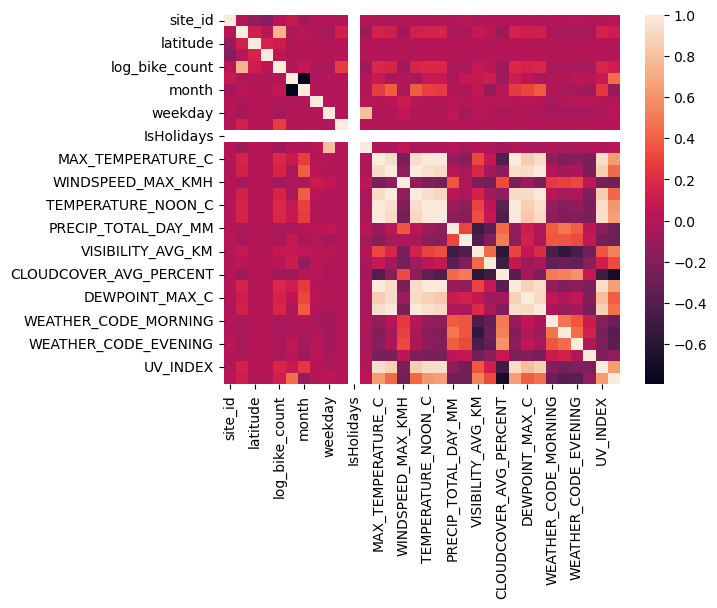

In [824]:
sns.heatmap(corr)

# Data analysis

Moyenne par heure par jour

<Figure size 1000x600 with 0 Axes>

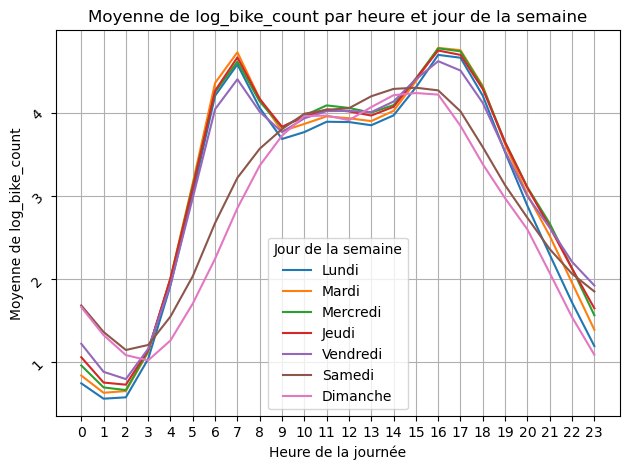

In [825]:

group1 = data.groupby(['weekday', 'hour'])['log_bike_count'].mean().unstack()

plt.figure(figsize=(10, 6))

group1.T.plot()

plt.title('Moyenne de log_bike_count par heure et jour de la semaine')
plt.xlabel('Heure de la journée')
plt.ylabel('Moyenne de log_bike_count')
plt.xticks(range(0, 24))
plt.yticks(rotation=45)
plt.legend(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], title='Jour de la semaine')

plt.grid(True)
plt.tight_layout()
plt.show()


On observe une différence notable entre jours de la semaine et week-end

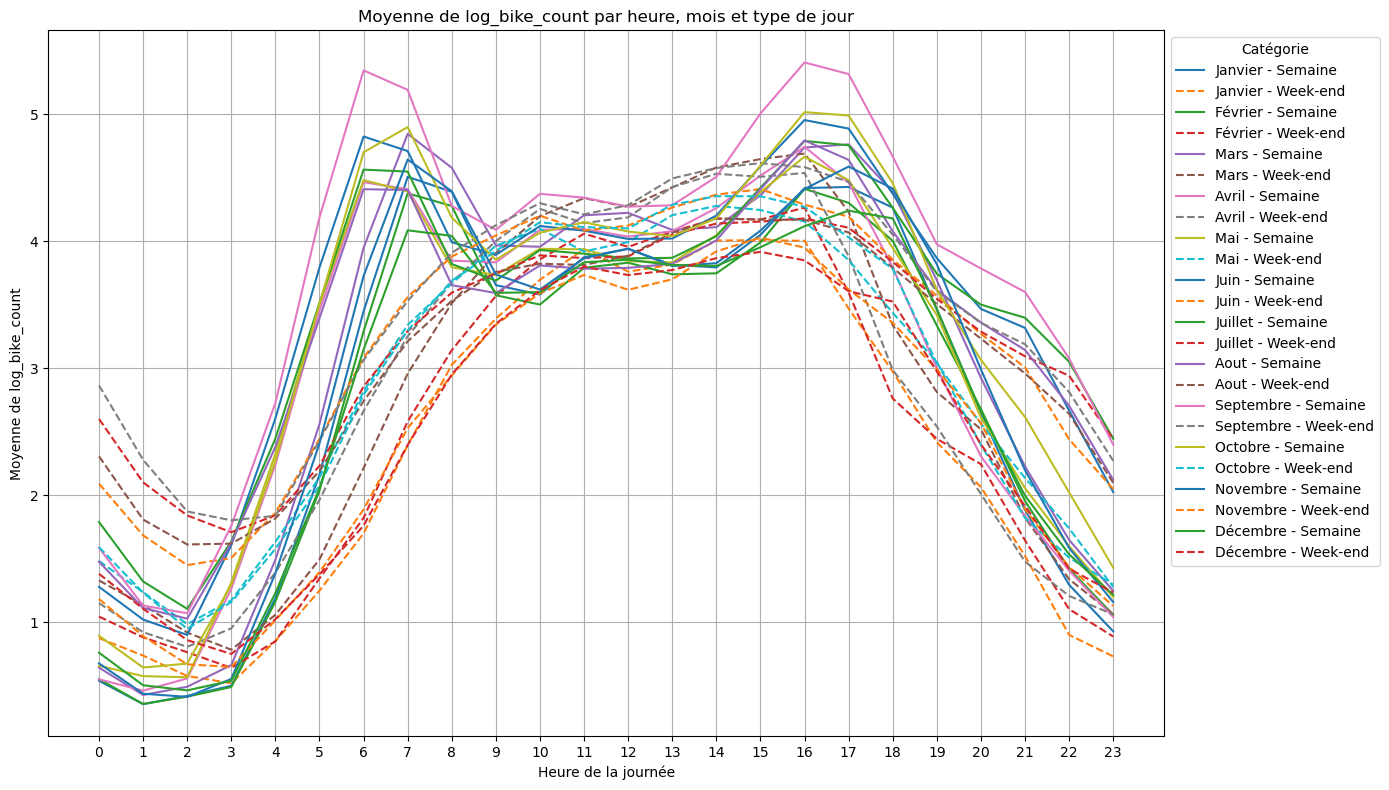

In [826]:
group2 = data.groupby(['month', 'IsWeekend', 'hour'])['log_bike_count'].mean()

plt.figure(figsize=(14, 8))

months = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
          'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

for month_index in range(1, 13):
    weekday_data = group2.loc[month_index, 0]
    weekend_data = group2.loc[month_index, 1]
    
    plt.plot(weekday_data.index, weekday_data.values, label=f'{months[month_index - 1]} - Semaine')
    plt.plot(weekend_data.index, weekend_data.values, '--', label=f'{months[month_index - 1]} - Week-end')

plt.title('Moyenne de log_bike_count par heure, mois et type de jour')
plt.xlabel('Heure de la journée')
plt.ylabel('Moyenne de log_bike_count')
plt.xticks(range(0, 24))
plt.legend(title='Catégorie', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

plt.show()


Différence notable entre semaine et week-end

# One-way ANOVA

In [827]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# One-Way ANOVA function
def perform_anova(target, explanatory, df):
    """
    Get ANOVA R-squared, F-statistic, P-value 
    for each indendent variable by returning a result table
    """
    # Create a result_table to store ANOVA results
    result_table = []
    
    # Iterate the features
    for column in explanatory.columns:

        # Specify the ANOVA formula
        formula = f'{target.name} ~ {column}'
        
        # Fit the ANOVA model
        result = ols(formula, data=df).fit()

        # Extract R-squared, F-statistic, and p-value from the result object
        result_table.append([column, result.rsquared, result.fvalue, result.f_pvalue])
    
    # Create a DataFrame to display the results
    table = pd.DataFrame(result_table, 
                         columns=['Explanatory Variable', 
                                  'R-squared', 
                                  'F-statistic', 
                                  'P-value'])
    return table

# Define target, explanatory variables and the dataset for ANOVA analysis
df = data.select_dtypes(include=['int', 'float']) # df_geo_weather is our merged dataset including all our independant variables for analysis
target = df['log_bike_count']
explanatory = df.drop(columns='log_bike_count')

# Apply the function
perform_anova(target, explanatory, df)

,Explanatory Variable,R-squared,F-statistic,P-value
0,site_id,4.450240e-04,220.046135,0.0
1,bike_count,5.454633e-01,593107.697934,0.0
2,latitude,1.280990e-02,6413.306065,0.0
3,longitude,1.991217e-03,986.100472,0.0
4,year,2.601614e-05,12.858528,0.000336
5,month,3.068707e-03,1521.343288,0.0
6,day,1.773123e-04,87.650173,0.0
7,weekday,3.061115e-03,1517.567842,0.0
8,hour,7.456390e-02,39821.646513,0.0
9,IsHolidays,-8.215650e-15,NaN,nan


toutes les p-value < 0.05, donc il y a une influence "significatives" de ces variables sur log_bike_count 

In [828]:
data.dtypes

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
bike_count                          float64
date                         datetime64[ns]
counter_installation_date    datetime64[ns]
coordinates                        category
counter_technical_id               category
latitude                            float64
longitude                           float64
log_bike_count                      float64
year                                  int64
month                                 int64
day                                   int64
weekday                               int64
hour                                  int64
IsHolidays                            int64
IsWeekend                             int64
DATE                         datetime64[ns]
MAX_TEMPERATURE_C                     int64
MIN_TEMPERATURE_C                     int64
WINDSPEED_MAX_KMH               

In [829]:
data = data.drop(columns = ["counter_name", "site_name","counter_installation_date", "coordinates","counter_technical_id"])

# Test

In [830]:
data_test = pd.read_parquet(Path("data") / "final_test.parquet")
data_test

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
...,...,...,...,...,...,...,...,...,...,...
51435,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 11:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980
51436,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980
51437,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 17:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980
51438,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 18:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980


In [831]:
def data_processing(X):
    X = _encode_dates(X)
    min_date,max_date = X['date'].min().strftime('%Y-%m-%d'), X['date'].max().strftime('%Y-%m-%d')
    X["IsHolidays"] = X["date"].isin(vancances).astype(int)
    X['IsWeekend'] = X['weekday'].apply(lambda x: 1 if x >= 5 else 0)
    X_meteo = pd.read_csv('external_data/export-paris0.csv')
    X_meteo = X_meteo.drop(columns = ['TEMPERATURE_NIGHT_C', 'SUNRISE', 'SUNSET'] )
    X_meteo = X_meteo[(X_meteo['DATE'] > min_date) & (X_meteo['DATE'] < max_date)]
    X_meteo['DATE'] = pd.to_datetime(X_meteo['DATE'])
    X_meteo["year"] = X_meteo["DATE"].dt.year
    X_meteo["month"] = X_meteo["DATE"].dt.month
    X_meteo["day"] = X_meteo["DATE"].dt.day
    X = pd.merge(X, X_meteo, on=['year', 'month', 'day'])
    X = X.drop(columns = ["DATE", "counter_name", "site_name","counter_installation_date", "coordinates","counter_technical_id"])
    return X

data_test = data_processing(data_test)
data_test

,counter_id,site_id,date,latitude,longitude,year,month,day,weekday,hour,...,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_MORNING,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION
0,100007049-102007049,100007049,2021-09-11 00:00:00,48.846028,2.375429,2021,9,11,5,0,...,25,14,17,116,116,116,0.0,5,11.6,météo favorable
1,100007049-102007049,100007049,2021-09-11 01:00:00,48.846028,2.375429,2021,9,11,5,1,...,25,14,17,116,116,116,0.0,5,11.6,météo favorable
2,100007049-102007049,100007049,2021-09-11 03:00:00,48.846028,2.375429,2021,9,11,5,3,...,25,14,17,116,116,116,0.0,5,11.6,météo favorable
3,100007049-102007049,100007049,2021-09-11 04:00:00,48.846028,2.375429,2021,9,11,5,4,...,25,14,17,116,116,116,0.0,5,11.6,météo favorable
4,100007049-102007049,100007049,2021-09-11 06:00:00,48.846028,2.375429,2021,9,11,5,6,...,25,14,17,116,116,116,0.0,5,11.6,météo favorable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48915,300014702-353245971,300014702,2021-09-26 02:00:00,48.839770,2.301980,2021,9,26,6,2,...,25,13,18,116,116,122,0.0,6,8.8,météo favorable
48916,300014702-353245971,300014702,2021-09-26 04:00:00,48.839770,2.301980,2021,9,26,6,4,...,25,13,18,116,116,122,0.0,6,8.8,météo favorable
48917,300014702-353245971,300014702,2021-09-26 09:00:00,48.839770,2.301980,2021,9,26,6,9,...,25,13,18,116,116,122,0.0,6,8.8,météo favorable
48918,300014702-353245971,300014702,2021-09-26 10:00:00,48.839770,2.301980,2021,9,26,6,10,...,25,13,18,116,116,122,0.0,6,8.8,météo favorable


Train / test split du starting_kit : 

In [832]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

In [833]:
bike_data = data
X = bike_data.drop(columns = ['bike_count','log_bike_count'])
y = bike_data['log_bike_count']

In [834]:

cat_cols_df = bike_data.select_dtypes(include=['object', 'category'])
num_cols_df = bike_data.select_dtypes(include=['int', 'float'])
cat_cols = list(cat_cols_df.columns)
num_cols = list(num_cols_df.columns)

cat_cols

['counter_id', 'OPINION']

In [835]:
print(len(num_cols))
num_cols

32


['site_id',
 'bike_count',
 'latitude',
 'longitude',
 'log_bike_count',
 'year',
 'month',
 'day',
 'weekday',
 'hour',
 'IsHolidays',
 'IsWeekend',
 'MAX_TEMPERATURE_C',
 'MIN_TEMPERATURE_C',
 'WINDSPEED_MAX_KMH',
 'TEMPERATURE_MORNING_C',
 'TEMPERATURE_NOON_C',
 'TEMPERATURE_EVENING_C',
 'PRECIP_TOTAL_DAY_MM',
 'HUMIDITY_MAX_PERCENT',
 'VISIBILITY_AVG_KM',
 'PRESSURE_MAX_MB',
 'CLOUDCOVER_AVG_PERCENT',
 'HEATINDEX_MAX_C',
 'DEWPOINT_MAX_C',
 'WINDTEMP_MAX_C',
 'WEATHER_CODE_MORNING',
 'WEATHER_CODE_NOON',
 'WEATHER_CODE_EVENING',
 'TOTAL_SNOW_MM',
 'UV_INDEX',
 'SUNHOUR']

In [836]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

In [837]:
pipeline_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaling',MinMaxScaler())
])

In [838]:
pipeline_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
])

In [839]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', pipeline_num, num_cols),
        ('cat', pipeline_cat, cat_cols)])

In [840]:
# List of regression models to test
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor()),
    ('SVR', SVR()),
    ('Decision Tree', DecisionTreeRegressor())
]

In [ ]:
# To store results
results = {}

# Define a custom scorer for RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Loop over models and evaluate
for name, model in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Assuming preprocessor is already defined
        ('regressor', model)
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=5, scoring=rmse_scorer)  # Replace X, y with your data
    results[name] = np.mean(scores)

# Print results
for name, score in results.items():
    print(f"{name}: RMSE = {score:.2f}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'bike_count'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/sklearn/utils/__init__.py", line 448, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3804, in get_loc
    raise KeyError(key) from err
KeyError: 'bike_count'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 724, in fit_transform
    self._validate_column_callables(X)
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 426, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "/Users/samy/anaconda3/lib/python3.10/site-packages/sklearn/utils/__init__.py", line 456, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe
